# Chapter 5 - Lab 5 - Exercise
> Author : Badr TAJINI - Large Language model (LLMs) - ESIEE 2024-2025

> Response by Paul CASCARINO E5-DSIA

#### 0. Setup

In [39]:
import torch
import tiktoken
from previous_labs import GPTModel, generate_text_simple, create_dataloader_v1
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os
import urllib.request


file_path = "the-verdict.txt"
url = "https://huggingface.co/datasets/DarwinAnim8or/the-verdict/blob/main/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()



GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); 


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches





def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


KeyboardInterrupt: 

In [ ]:
#train
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [40]:
# I will use the open ai model
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))



import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 969kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 30.1kiB/s]
model.ckpt.data-00000-of-00001:  84%|████████▍ | 419M/498M [00:46<00:08, 9.24MiB/s] 

# Exercise 5.1: Temperature-scaled softmax scores and sampling probabilities

### How does temperature-based scaling of the `softmax` probability distribution impact the sampling frequency of the specific lexical token `"pizza"`?

#### 1. Primary token of interest: `"pizza"`

##### 1.1 Temperature

In [70]:
# Example: Apply temperature scaling and print sample frequencies for different temperatures
temperature = 0.1
probas = softmax_with_temperature(next_token_logits, temperature)
print(f"Sampled tokens with temperature {temperature}:")
print_sampled_tokens(probas)

# Lower temperature (e.g., 0.1) makes the output more deterministic
temperature = 1
probas = softmax_with_temperature(next_token_logits, temperature)
print(f"\nSampled tokens with temperature {temperature}:")
print_sampled_tokens(probas)

# Higher temperature (e.g., 2.0) introduces more randomness
temperature = 2.0
probas = softmax_with_temperature(next_token_logits, temperature)
print(f"\nSampled tokens with temperature {temperature}:")
print_sampled_tokens(probas)

# Higher temperature (e.g., 5.0) introduces more randomness
temperature = 5.0
probas = softmax_with_temperature(next_token_logits, temperature)
print(f"\nSampled tokens with temperature {temperature}:")
print_sampled_tokens(probas)

# Higher temperature (e.g., 10.0) introduces more randomness
temperature = 10.0
probas = softmax_with_temperature(next_token_logits, temperature)
print(f"\nSampled tokens with temperature {temperature}:")
print_sampled_tokens(probas)



Sampled tokens with temperature 0.1:
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward

Sampled tokens with temperature 1:
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you

Sampled tokens with temperature 2.0:
158 x closer
20 x every
12 x effort
391 x forward
37 x inches
5 x moves
4 x pizza
340 x toward
33 x you

Sampled tokens with temperature 5.0:
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you

Sampled tokens with temperature 10.0:
142 x closer
82 x every
93 x effort
168 x forward
114 x inches
83 x moves
62 x pizza
165 x toward
91 x you


The results show how temperature affects the sampling distribution. At a temperature of 0.1, the model's output is highly deterministic, with "forward" dominating the samples and other tokens like "pizza" being virtually never selected. At a temperature of 1.0, the model shows more balanced diversity, with "closer" and "forward" still dominant, but tokens like "pizza" start to appear, albeit infrequently. Finally, at a temperature of 2.0, the sampling becomes more random, allowing less frequent tokens like "pizza" to appear more often, though "closer" and "forward" remain frequent. This demonstrates how lower temperatures make the model more predictable, while higher temperatures increase diversity and randomness in token selection.

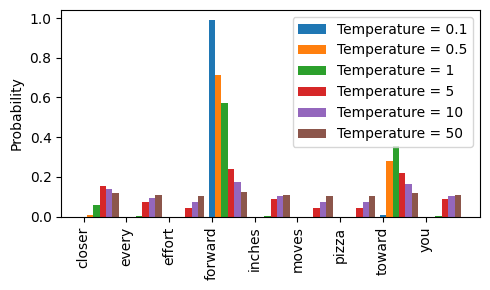

In [72]:
# Temperature values
temperatures = [0.1, 0.5, 1, 5, 10, 50] 

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]


# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

# Exercise 5.2: Different temperature and top-k settings

### How do variations in `temperature` and `top-k` sampling parameters influence the qualitative and probabilistic characteristics of token generation in stochastic language models?


- Temperature: The temperature parameter controls the randomness or creativity of the generated text.
  - Low temperature (e.g., 0.1–0.5) results in more deterministic outputs, where the model picks higher-probability tokens.
  - High temperature (e.g., 1.0–1.5) introduces more randomness, allowing the model to choose less likely tokens and thus generating more varied and creative outputs.

- Top-k Sampling: Top-k sampling involves restricting token generation to the k most likely candidates at each step.
  - Lower values of k (e.g., k=1) mean the model will always pick the most probable token (deterministic output).
  - Higher values of k provide more variety in the generated text by selecting from a broader range of tokens.


**We can see below results from different temperatures for our first "trained" model with low epochs to run it during hours:**


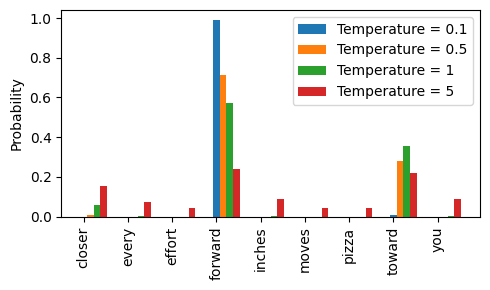

In [67]:

# Temperature values
temperatures = [0.1, 0.5, 1, 5] 

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]


# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

We can see that More the temperature is high, more the results will be various implies less probability in peak tha low temperature's results.

#### 1.1  Low `temperature` and `top-k` Scenarios

Let's test some example with the OpenAI model because mine is not trained as well



In [61]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=1,
    temperature=0.1
)

print("Very Low temp, Very Low top-k:\n", token_ids_to_text(token_ids, tokenizer))

Very Low temp, Very Low top-k:
 Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.

The third step is to understand the importance of your work.

The fourth step is


In [62]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=2,
    temperature=0.5
)

print("Low temp, Low top-k:\n", token_ids_to_text(token_ids, tokenizer))

Low temp, Low top-k:
 Every effort moves you forward.

The first step is to find a way to make the world a better place.

This is not a new idea.

In the past, the world was filled with people who were willing to work hard to make it


In the "Very Low temp, Very Low top-k" case, the output is highly repetitive, with the model continually focusing on the same theme: understanding the importance of work. This results in a rigid and repetitive structure without introducing any new ideas or variety. On the other hand, the "Low temp, Low top-k" output introduces more variation and a slightly broader perspective, shifting the focus towards making the world a better place. While still constrained and predictable, it brings in new elements of motivation and historical context, showing a slight improvement in creativity compared to the first case.

**To conclude :**

Low temperature and low top-k configurations can be particularly useful for tasks where accurate, coherent, and predictable language is crucial, such as:

- Machine Translation
- Code Generation
- Data-to-Text Tasks

The generated text will be more deterministic, with the model selecting the most probable next token. The output will often be highly structured and coherent, sticking closely to the training data and avoiding significant deviations. The diversity of outputs is constrained, meaning that different runs with the same input prompt are likely to produce very similar results.


#### 1.2 High `temperature` and `top-k` Scenarios

In [65]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=5
)

print("Very High temp, Very high top-k:\n", token_ids_to_text(token_ids, tokenizer))

Very High temp, Very high top-k:
 Every effort moves you through life slowly but often not through punishment (usually life), through loss(less a blessing - much closer if desired.) Then once everything (usually personal goals etc ...). you start back backtrack, hoping for the "best", your dream "will


In [64]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=5,
    temperature=2
)

print("High temp, high top-k:\n", token_ids_to_text(token_ids, tokenizer))

High temp, high top-k:
 Every effort moves you, not me, into the abyss," said a man who asked for anonymity to talk candidly.

The incident has prompted an investigation and an appeal for the police to investigate. Police are investigating.

A spokesman said: "We will


In the "Very High temp, Very High top-k" output, the text is highly unpredictable and abstract, with a mix of vague and disjointed thoughts. It moves through topics like life, loss, and personal goals, but the coherence is weak, and the text feels more like a fragmented stream of consciousness. In contrast, the "High temp, high top-k" output is slightly more grounded but still maintains some level of unpredictability. It introduces a more direct narrative with a man speaking candidly, followed by a reference to a police investigation. This shift towards a more structured context gives the output more coherence while still keeping an element of surprise.


*To conclude :**

Higher temperature and top-k values are useful in domains where creativity, imagination, and novelty are valued over coherence and precision. These include:

- Creative Writing
- Poetry Generation
- Story Generation

The model will generate more diverse and creative text, sometimes introducing unexpected tokens. As randomness increases, the generated output may be less coherent and more disjointed. This is especially true with higher temperatures, where the model may select tokens that are less likely to fit in the context. The variety in the outputs increases significantly, making it more likely to generate unique and varied responses across multiple runs with the same prompt.


# Exercise 5.3: Deterministic behavior in the decoding functions

### What specific configuration parameters within the `generate` function can systematically eliminate randomness to ensure consistently reproducible generative outputs?

#### 1. Random Seed Initialization:

We need to fix the random seed first. Let's do that with : 


In [74]:
torch.manual_seed(123)

#### 2. Temperature scaling

et the temperature to 0.0, which suppresses the softmax output's variability. Lowering the temperature makes the model output the token with the highest probability, completely removing randomness.

#### 3. Top-k pruning mechanism

By using top_k=1, we ensure that only the highest probability token is sampled, further reducing randomness in the selection process.

#### 4. Samplig strategy

Use a greedy sampling strategy (i.e., always pick the token with the highest probability) instead of probabilistic methods such as multinomial sampling, which introduces variability.

##### 5. Conclusion


In [84]:
token_ids = generate(
    model=gpt, # model isn't well trained i don't run all epochs as i said before... 
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=1,
    context_size=NEW_CONFIG["context_length"],
    top_k=1,
    temperature=0
)

print("Very Low temp, Very Low top-k:\n", token_ids_to_text(token_ids, tokenizer))

Very Low temp, Very Low top-k:
 Every effort moves you forward


# Exercise 5.4: Continued pretraining

### How can we effectively restore a machine learning model's training state across separate computational sessions, enabling seamless continuation of the pretraining process?

#### 1. Load previously saved model weights

To load the model weights from the previously saved checkpoint we can create teh function *load_model_weights*, as below :

In [103]:
def load_model_weights(model, checkpoint_path="model.pth"):
    checkpoint = torch.load(checkpoint_path)
    
    # Load each layer's parameters directly (matching keys in the checkpoint)
    model_state_dict = model.state_dict()
    for key, value in checkpoint.items():
        if key in model_state_dict:
            model_state_dict[key] = value
        else:
            print(f"Skipping parameter: {key}")  # If the key doesn't match, it will be skipped
    
    model.load_state_dict(model_state_dict)
    print(f"Model weights loaded from {checkpoint_path}")


#### 2. Reconstruct optimizer internal state

To reconstruct the optimizer state and to continue training without losing progress we create the function *load_optimizer_state*

In [105]:
def load_optimizer_state(optimizer, checkpoint_path="model.pth"):
    checkpoint = torch.load(checkpoint_path)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Optimizer state restored from {checkpoint_path}")


#### 3. Reinitiate training using `train_model_simple` function

We can resume training using the train_model_simple function :

In [107]:
# Example of calling the training resumption function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load model and optimizer from the checkpoint
checkpoint_path = "model.pth"
load_model_weights(model, checkpoint_path)
load_optimizer_state(optimizer, checkpoint_path)

# Resume training
num_epochs = 1  # For one additional epoch
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer
)


C:\Users\paulc\AppData\Local\Temp\ipykernel_17036\3318896299.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Skipping parameter: model_state_dict
Skipping parameter: optimizer_state_dict
Model weights loaded from model.pth
Optimizer state restored from model.pth
Ep 1 (Step 000000): Train loss 1.683, Val loss 1.922
Ep 1 (Step 000005): Train loss 1.913, Val loss 1.921
Ep 1 (Step 000010): Train loss 1.775, Val loss 1.932
Ep 1 (Step 000015): Train loss 1.403, Val loss 1.916
Ep 1 (Step 000020): Train loss 1.404, Val loss 1.904
Ep 1 (Step 000025): Train loss 2.002, Val loss 1.924
Ep 1 (Step 000030): Train loss 1.888, Val loss 1.904
Ep 1 (Step 000035): Train loss 1.638, Val loss 1.886
Ep 1 (Step 000040): Train loss 1.391, Val loss 1.847
Ep 1 (Step 000045): Train loss 2.097, Val loss 1.857
Ep 1 (Step 000050): Train loss 1.665, Val loss 1.833
Ep 1 (Step 000055): Train loss 1.772, Val loss 1.800
Ep 1 (Step 000060): Train loss 1.713, Val loss 1.794
Ep 1 (Step 000065): Train loss 1.684, Val loss 1.759
Ep 1 (Step 000070): Train loss 1.696, Val loss 1.752
Ep 1 (Step 000075): Train loss 1.244, Val loss 1.76

#### 4. Complete one additional training epoch

Once the training is resumed, you can run one more epoch. This epoch will allow the model to continue learning from the last saved state.

In [ ]:
# After resuming training, you can save progress
def save_checkpoint(model, optimizer, epoch, global_step, checkpoint_path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "global_step": global_step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Save after completing the epoch

epoch=1
global_step=1

save_checkpoint(model, optimizer, epoch + 1, global_step + len(train_loader))


Checkpoint saved at checkpoint.pth


# Exercise 5.5: Training and validation set losses of the pretrained model

### What are the comparative training and validation set losses when applying a pretrained OpenAI `GPTModel` to the "The Verdict" dataset?


In [113]:
torch.save(gpt.state_dict(), "modelgpt.pth")

In [123]:
# Example of calling the training resumption function
optimizer_gpt = torch.optim.Adam(gpt.parameters(), lr=1e-4)

# Load model and optimizer from the checkpoint
checkpoint_path_gpt = "modelgpt.pth"
load_model_weights(gpt, checkpoint_path_gpt)
#load_optimizer_state(optimizer_gpt, checkpoint_path_gpt)

# Resume training
num_epochs_gpt = 1  # For one additional epoch
train_losses, val_losses, track_tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer_gpt, device, num_epochs_gpt, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer
)


# Save after completing the epoch
save_checkpoint(gpt, optimizer_gpt, epoch + 1, global_step + len(train_loader))

C:\Users\paulc\AppData\Local\Temp\ipykernel_17036\3318896299.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model weights loaded from modelgpt.pth


KeyboardInterrupt: 

# Exercise 5.6: Trying larger models

### How do generative text characteristics vary across different GPT-2 model scales, specifically comparing the 124 million and 1,558 million parameter configurations?

In [ ]:
model_name = "gpt2-xl (1558M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt_big = GPTModel(NEW_CONFIG)
gpt_big = GPTModel(NEW_CONFIG)
gpt_big.eval();

    
load_weights_into_gpt(gpt_big, params)
gpt_big.to(device);

In [ ]:
token_ids = generate(
    model=gpt, # model isn't well trained i don't run all epochs as i said before... 
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=1,
    context_size=NEW_CONFIG["context_length"],
    top_k=1,
    temperature=0
)

print("gpt S", token_ids_to_text(token_ids, tokenizer))

In [ ]:
token_ids = generate(
    model=gpt_big, # model isn't well trained i don't run all epochs as i said before... 
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=1,
    context_size=NEW_CONFIG["context_length"],
    top_k=1,
    temperature=0
)

print("gpt XL ", token_ids_to_text(token_ids, tokenizer))